# Running inference on the test dataset

This notebook will use the trained models to make predictions on the test dataset, calculate scoring metrics, and display the model predictions at the same time.

## 0. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib
import json
import torch
import os
from torchvision.transforms import v2
from pathlib import Path
from joblib import load
from tqdm import tqdm
from PIL import Image

from utils.dataset import TorchFloodDataset
from utils.inference import TorchInference
from architectures.transformers import BaseViT, FloodViT
from architectures.unet import BaseUNet

# LATEX font
font = {'family' : 'serif',
         'size'   : 12,
         'serif':  'cmr10'
         }

matplotlib.rc('font', **font)
matplotlib.rc('axes', unicode_minus=False)

## 1. Define constants and functions

### Constants

In [2]:
# Filepaths (change as necessary)
FIRST_TEST_X = "E:\\RSI09\\v4\\test_99.1717616_17.1286267_X.npy"
FIRST_TEST_Y = "E:\\RSI09\\v4\\test_99.1717616_17.1286267_Y.npy"
FIRST_TEST_META = "E:\\RSI09\\v4\\test_99.1717616_17.1286267_meta.jsonl"

SECOND_TEST_X = "E:\\RSI09\\v4\\test_4.7049263_9.9129092_X.npy"
SECOND_TEST_Y = "E:\\RSI09\\v4\\test_4.7049263_9.9129092_Y.npy"
SECOND_TEST_META = "E:\\RSI09\\v4\\test_4.7049263_9.9129092_meta.jsonl"

# Use training stats for normalization
MEAN_PATH = "./output/proc_data_mean.json"
STD_PATH = "./output/proc_data_std.json"

# Path to model weights
BASE_VIT_WEIGHTS = "./output/base_vit_best_val_loss.pt"
FLOOD_VIT_WEIGHTS = "./output/flood_vit_best_val_loss.pt"
BASE_UNET_WEIGHTS = "./output/base_unet_best_val_loss.pt"
BASE_TREE_WEIGHTS = "./output/base_tree.pkl"

# Path to save metrics to
FIRST_SAVE_PATH = "./results/first_event"
SECOND_SAVE_PATH = "./results/second_event"

# For inference
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4

# Make the directories for the two save paths if they don't exist
Path(FIRST_SAVE_PATH).mkdir(parents=True, exist_ok=True)
Path(SECOND_SAVE_PATH).mkdir(parents=True, exist_ok=True)

# Colours to use to draw segmentation mask, in RGB format
MASK_COLOURS = {
    "flood_vit": (40, 155, 235),
    "base_vit": (40, 155, 235),
    "base_unet": (40, 155, 235),
    "base_tree": (40, 155, 235),
    "ground_truth": (40, 155, 235)
}

### Datasets and Dataloaders

In [3]:
# Load mean and std
with open(MEAN_PATH, 'r') as f:
    means = json.load(f)

with open(STD_PATH, 'r') as f:
    stds = json.load(f)

# Apply standardisation
transform = v2.Normalize(mean=means, std=stds)

In [4]:
first_test_ds = TorchFloodDataset(X=np.load(FIRST_TEST_X, mmap_mode="r"), 
                                  y=np.load(FIRST_TEST_Y, mmap_mode="r"), 
                                  transform=transform,
                                  do_augment=False) 

first_test_dataloader = torch.utils.data.DataLoader(first_test_ds, 
                                                    shuffle=False, # do not shuffle to preserve order!
                                                    batch_size=BATCH_SIZE)


second_test_ds = TorchFloodDataset(X=np.load(SECOND_TEST_X, mmap_mode="r"), 
                                   y=np.load(SECOND_TEST_Y, mmap_mode="r"),
                                   transform=transform,
                                   do_augment=False)

second_test_dataloader = torch.utils.data.DataLoader(second_test_ds, 
                                                     shuffle=False, # do not shuffle to preserve order!
                                                     batch_size=BATCH_SIZE)

### Helper function to plot results

In [5]:
# model_preds is an array of tensors 
# fig_titles specifies which model preds correspond to which model for plotting
# colors is a list of what colors in (r, g, b) tuples to plot the segmentation mask with - 
# it should be in the same order as model_preds array

def plot_results(model_preds, model_label, fig_titles, n_rows, n_cols, colors):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10), dpi=600) 

    for i, ax in enumerate(axes.flatten()):
        if i == len(model_preds):
            img_colors = [(0.3, 0, 0), tuple(c / 255 for c in colors[i])]                
            cmap = ListedColormap(img_colors)

            im = ax.imshow(model_label, interpolation='nearest', aspect='equal', cmap=cmap)  # auto aspect for varying shapes
            ax.set_title(f'Ground Truth', fontsize=24)
            ax.axis('off')  # remove axes for cleaner look
            continue
            
        elif i > len(model_preds):
            ax.axis('off')
            ax.set_xticks([])
            ax.set_yticks([])
            continue
        
        img_colors = [(0.3, 0, 0), tuple(c / 255 for c in colors[i])]                
        cmap = ListedColormap(img_colors)
        
        im = ax.imshow(model_preds[i], interpolation='nearest', aspect='equal', cmap=cmap)  # auto aspect for varying shapes
        ax.set_title(fig_titles[i], fontsize=24)
        ax.axis('off')  # remove axes for cleaner look

    plt.tight_layout()
    plt.show()

### Helper function to save segmentation masks

In [6]:
# mask - binarised segmentation mask in numpy array, of size H x W
# color - tuple of red, green, blue values: colour of the segmented regions in the final image
# dir - directory to save segmentation mask in
# model_name - name of model, used in the file name of the saved mask
def save_segmentation_mask(mask, color, dir, model_name): 
    mask_np = mask.astype(int)
    rgba = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
    
    # Fill colours
    red, green, blue = color
    rgba[:, :, 0] = red * mask_np
    rgba[:, :, 1] = green * mask_np
    rgba[:, :, 2] = blue * mask_np

    # Alpha channel so that the background pixels are transparent, while flooded pixels are semi-transparent
    # (useful for frontend display)
    rgba[:, :, 3] = 0.6 * 255 * mask_np

    # Save the numpy array as an image
    im = Image.fromarray(rgba)
    im.save(os.path.join(dir, f"{model_name}_mask.png"))


### Helper function to run inference on Decision Tree

In [7]:
# tree - DecisionTree model from sklearn
# dataloader - torch DataLoader class
# save_path - where to save output logs to
# meta_path - path to tile metadata for test events
def infer_tree(tree, dataloader, save_path, meta_path):
    # Create an inference class so we can calculate metrics and stitch tiles together, just pass in a dummy model
    dummy = BaseUNet(5, 1)
    inference = TorchInference(model=dummy, 
                            device=DEVICE, 
                            model_name="base_tree", 
                            test_loader=None, 
                            save_path=save_path)

    # Get the full numpy array from the dataloader
    print("Collating data for tree...")
    X = []
    y = []
    progress_bar = tqdm(dataloader, desc=f"Processing validation data")
    for i, (inputs, labels, *_) in enumerate(progress_bar):
        inputs = torch.nn.functional.avg_pool2d(inputs, kernel_size=10, stride=10)
        X.append(inputs)
        y.append(labels)
    X = torch.cat(X, dim=0)
    y = torch.cat(y, dim=0)

    X_test = X.permute(0, 2, 3, 1).reshape(-1, 5).numpy()

    # Run inference
    print("Running inference on tree...")
    y_preds = tree.predict(X_test)
    y_probs = tree.predict_proba(X_test)[:, 1]
    # Reshape back
    y_preds = y_preds.reshape(y.shape[0], y.shape[1], y.shape[2])
    y_probs = y_probs.reshape(y.shape[0], y.shape[1], y.shape[2])
    
    # Rejoin tiles using inference class
    model_preds = inference.reconstruct_tiles(y_preds, meta_path)
    model_probs = inference.reconstruct_tiles(y_probs, meta_path)
    model_labels = inference.reconstruct_tiles(y, meta_path)

    # Calculate and save metrics
    inference.calculate_metrics(model_preds, model_probs, model_labels)
    inference.save_metrics()

    return model_preds, model_probs, model_labels

## 1. Infer on first test event

### Load all models

In [8]:
with open(BASE_TREE_WEIGHTS, "rb") as f:
    base_tree = load(f)

base_vit = BaseViT(embed_dim=256, 
                   depth=4, 
                   num_heads=4, 
                   mlp_dim=768,
                   dropout=0.1)
base_vit.load_state_dict(torch.load(BASE_VIT_WEIGHTS, weights_only=True))

flood_vit = FloodViT(embed_dim=256, 
                     depth=4, 
                     num_heads=4, 
                     mlp_dim=768,
                     dropout=0.1).to(DEVICE)
flood_vit.load_state_dict(torch.load(FLOOD_VIT_WEIGHTS, weights_only=True))

base_unet = BaseUNet(5, 1)
base_unet.load_state_dict(torch.load(BASE_UNET_WEIGHTS, weights_only=True))

<All keys matched successfully>

### Define inference classes

In [9]:
# Define inference classes for the 3 Pytorch models
base_vit_inference = TorchInference(model=base_vit, 
                                    device=DEVICE, 
                                    model_name="base_vit", 
                                    test_loader=first_test_dataloader, 
                                    save_path=FIRST_SAVE_PATH)

flood_vit_inference = TorchInference(model=flood_vit, 
                                     device=DEVICE, 
                                     model_name="flood_vit", 
                                     test_loader=first_test_dataloader, 
                                     save_path=FIRST_SAVE_PATH)

base_unet_inference = TorchInference(model=base_unet, 
                                     device=DEVICE,
                                     model_name="base_unet", 
                                     test_loader=first_test_dataloader, 
                                     save_path=FIRST_SAVE_PATH)

### Obtain predictions

In [10]:
base_tree_preds, base_tree_probs, base_tree_labels = infer_tree(base_tree, first_test_dataloader, FIRST_SAVE_PATH, FIRST_TEST_META)
base_vit_preds, base_vit_probs, base_vit_labels = base_vit_inference.infer_full_test_event(FIRST_TEST_META)
flood_vit_preds, flood_vit_probs, flood_vit_labels = flood_vit_inference.infer_full_test_event(FIRST_TEST_META)
base_unet_preds, base_unet_probs, base_unet_labels = base_unet_inference.infer_full_test_event(FIRST_TEST_META)

Collating data for tree...


Processing validation data: 100%|██████████| 152/152 [00:59<00:00,  2.56it/s]


Running inference on tree...
Accuracy: 83.03 %
F1 Score: 0.2124
Precision: 0.3617
Recall: 0.1503
ROC AUC: 0.7867
IOU: 0.1188


Testing: 100%|██████████| 152/152 [00:35<00:00,  4.33it/s]


Threshold: 0.5
Accuracy: 83.59 %
F1 Score: 0.5682
Precision: 0.4739
Recall: 0.7096
ROC AUC: 0.8811
IOU: 0.3969


Testing: 100%|██████████| 152/152 [00:46<00:00,  3.27it/s]


Threshold: 0.5
Accuracy: 84.89 %
F1 Score: 0.5944
Precision: 0.5025
Recall: 0.7274
ROC AUC: 0.8878
IOU: 0.4229


Testing: 100%|██████████| 152/152 [00:32<00:00,  4.65it/s]


Threshold: 0.5
Accuracy: 80.06 %
F1 Score: 0.5117
Precision: 0.4079
Recall: 0.6864
ROC AUC: 0.8381
IOU: 0.3438


### Plot results

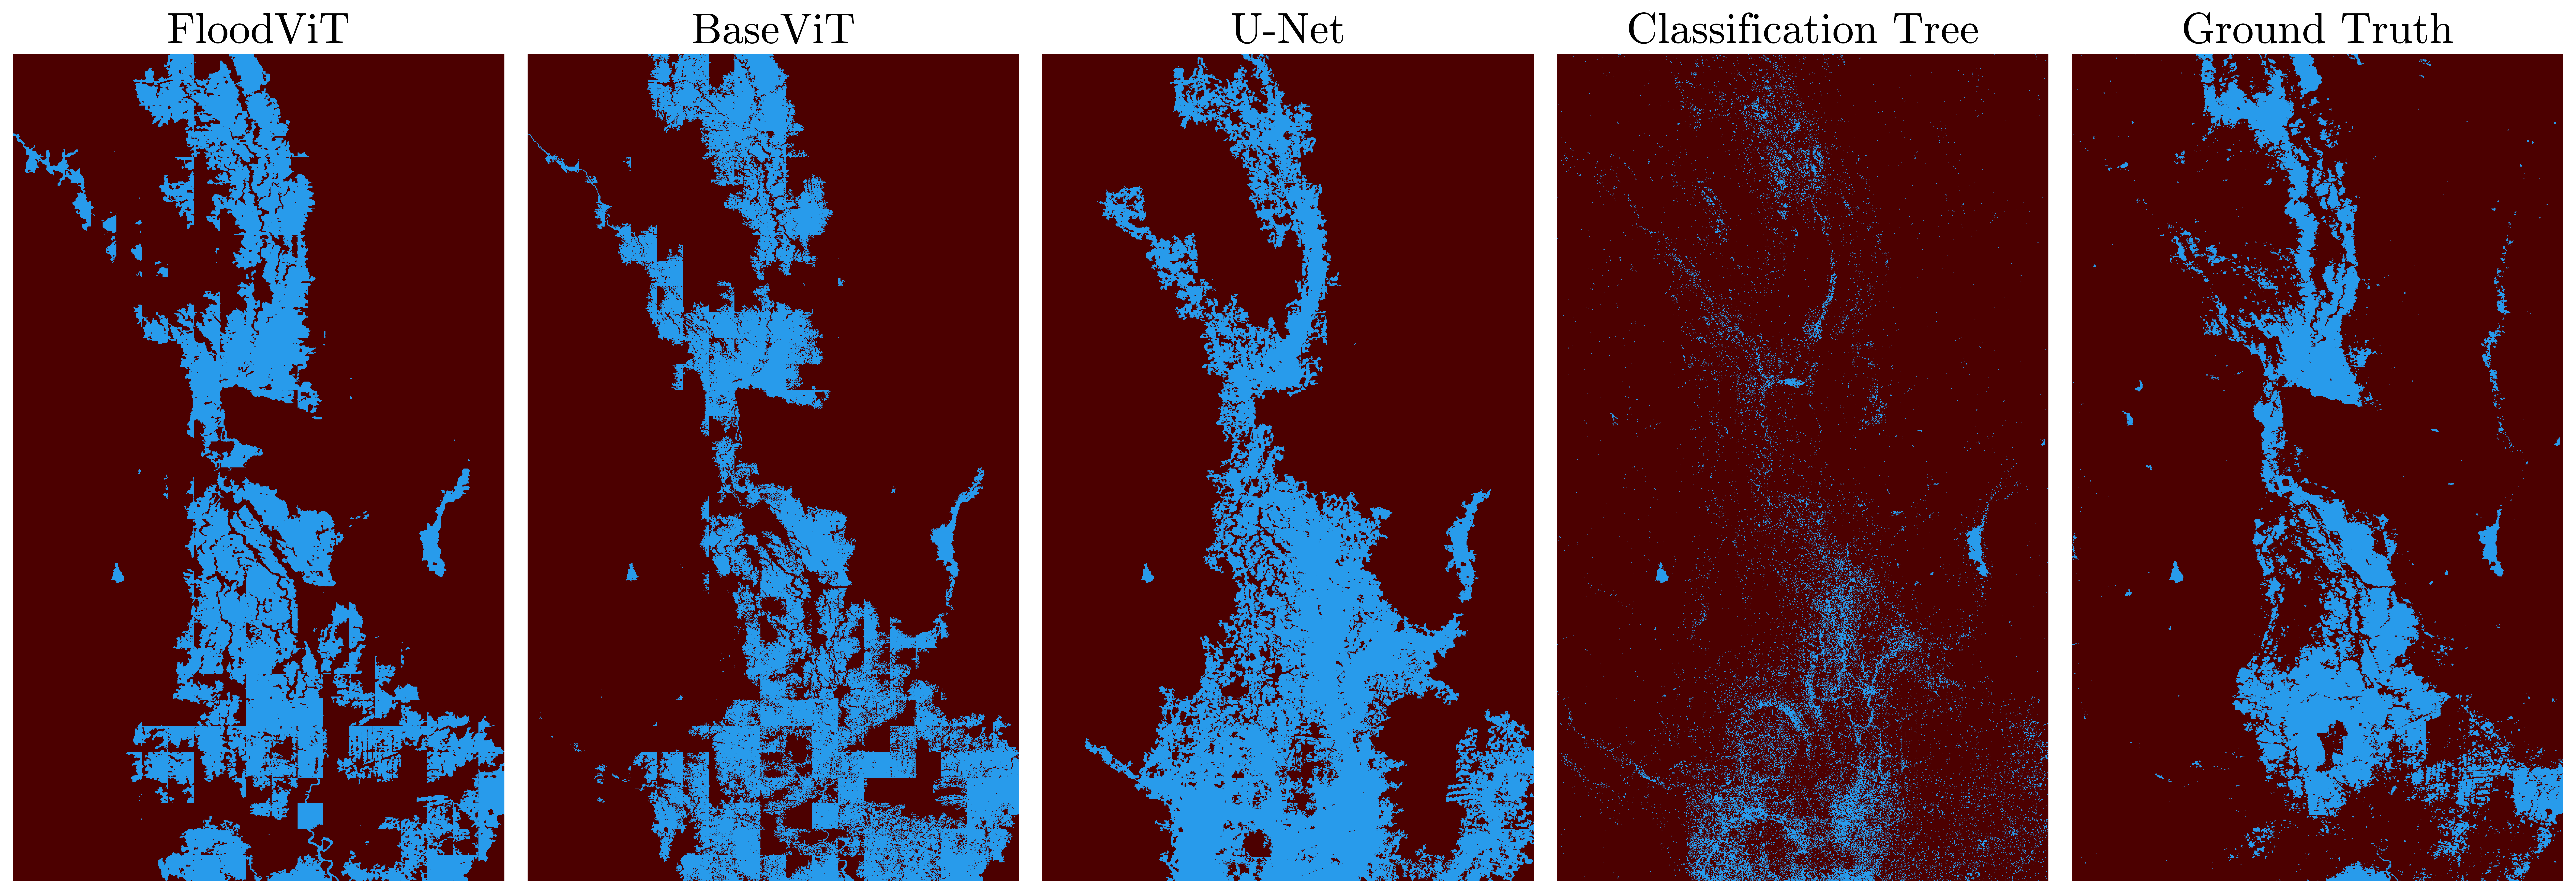

In [11]:
plot_results([flood_vit_preds, base_vit_preds, base_unet_preds, base_tree_preds], 
             base_vit_labels, 
             ["FloodViT", "BaseViT", "U-Net", "Classification Tree"], 
             1, 
             5,
             list(MASK_COLOURS.values()))

### Save results

In [12]:
save_segmentation_mask(flood_vit_preds, (106, 27, 154), FIRST_SAVE_PATH, "flood_vit")
save_segmentation_mask(base_vit_preds, (106, 27, 154), FIRST_SAVE_PATH, "base_vit")
save_segmentation_mask(base_unet_preds, (106, 27, 154), FIRST_SAVE_PATH, "base_unet")
save_segmentation_mask(base_tree_preds, (106, 27, 154), FIRST_SAVE_PATH, "base_tree")
save_segmentation_mask(base_vit_labels, MASK_COLOURS["ground_truth"], FIRST_SAVE_PATH, "ground_truth")

## 2. Infer on the second flood event

### Change dataset

In [13]:
# Define inference classes for the 3 Pytorch models
base_vit_inference.test_loader = second_test_dataloader
base_vit_inference.save_path = SECOND_SAVE_PATH

flood_vit_inference.test_loader = second_test_dataloader
flood_vit_inference.save_path = SECOND_SAVE_PATH

base_unet_inference.test_loader = second_test_dataloader
base_unet_inference.save_path = SECOND_SAVE_PATH

### Obtain predictions

In [14]:
base_tree_preds, base_tree_probs, base_tree_labels = infer_tree(base_tree, second_test_dataloader, SECOND_SAVE_PATH, SECOND_TEST_META)
base_vit_preds, base_vit_probs, base_vit_labels = base_vit_inference.infer_full_test_event(SECOND_TEST_META)
flood_vit_preds, flood_vit_probs, flood_vit_labels = flood_vit_inference.infer_full_test_event(SECOND_TEST_META)
base_unet_preds, base_unet_probs, base_unet_labels = base_unet_inference.infer_full_test_event(SECOND_TEST_META)

Collating data for tree...


Processing validation data: 100%|██████████| 150/150 [01:02<00:00,  2.38it/s]


Running inference on tree...
Accuracy: 96.10 %
F1 Score: 0.2824
Precision: 0.4355
Recall: 0.2090
ROC AUC: 0.8579
IOU: 0.1644


Testing: 100%|██████████| 150/150 [00:34<00:00,  4.31it/s]


Threshold: 0.5
Accuracy: 96.67 %
F1 Score: 0.5189
Precision: 0.5521
Recall: 0.4895
ROC AUC: 0.8628
IOU: 0.3504


Testing: 100%|██████████| 150/150 [00:46<00:00,  3.22it/s]


Threshold: 0.5
Accuracy: 96.96 %
F1 Score: 0.5685
Precision: 0.5946
Recall: 0.5445
ROC AUC: 0.8885
IOU: 0.3971


Testing: 100%|██████████| 150/150 [00:33<00:00,  4.48it/s]


Threshold: 0.5
Accuracy: 97.01 %
F1 Score: 0.5536
Precision: 0.6140
Recall: 0.5040
ROC AUC: 0.9190
IOU: 0.3827


### Plot results

In [15]:
plot_results([flood_vit_preds, base_vit_preds, base_unet_preds, base_tree_preds], 
             base_vit_labels, 
             ["FloodViT", "BaseViT", "U-Net", "Classification Tree"], 
             2, 
             3,
             list(MASK_COLOURS.values()))

### Save results

In [16]:
save_segmentation_mask(flood_vit_preds, (106, 27, 154), SECOND_SAVE_PATH, "flood_vit")
save_segmentation_mask(base_vit_preds, (106, 27, 154), SECOND_SAVE_PATH, "base_vit")
save_segmentation_mask(base_unet_preds, (106, 27, 154), SECOND_SAVE_PATH, "base_unet")
save_segmentation_mask(base_tree_preds, (106, 27, 154), SECOND_SAVE_PATH, "base_tree")
save_segmentation_mask(base_vit_labels, MASK_COLOURS["ground_truth"], SECOND_SAVE_PATH, "ground_truth")